# 4 Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Pre-Processing and Training Data](#4_Pre-Processing_and_Training_Data)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports](#4.3_Imports)
  * [4.4 Load Data](#4.4_Load_Data)
  * [4.5 Train/Test Split](#4.5_Train/Test_Split)
  * [4.6 Initial Not-Even-A-Model](#4.6_Base_Model)
  * [4.7 Initial Models](#4.7_Initial_Models)
    * [4.7.1 Naive Baye's Classifier](#4.7.1_Naive_Bayes)
    * [4.7.2 Transform Data](#4.7.2_Transform_Data)
    * [4.7.3 Split the newly transformed Data](#4.7.3_Split_PCA_Data)
    * [4.7.4 Decision Tree Classifier](#4.7.4_Decision_Tree)
    * [4.7.5 KNN Model](#4.7.5_KNN)
    * [4.7.6 Random Forest Model](#4.7.6_Random_Forest)
    * [4.7.7 AdaBoost Model](#4.7.7_Adaboost)
    * [4.7.8 Logisitic Regression Model](#4.7.8_Logistic_Regression)
    * [4.7.9 SVC Model](#4.7.9_SVM)
  * [4.8 Summary](#4.8_Summary)

## 4.2 Introduction<a id='4.2_Introduction'></a>

We are ready to proceed with testing out different classifier models with our prefume feature set.

We expect the ML models to predict the gender that would prefer a perfume given the notes in that perfume.

## 4.3 Imports<a id='4.3_Imports'></a>

In [67]:
import pandas as pd
import numpy as np
import os
import pickle
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, cross_val_predict, cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

from sklearn.feature_selection import SelectKBest, f_regression

## 4.4 Load Data<a id='4.4_Load_Data'></a>

In [2]:
perfume_data = pd.read_csv('../data/processed/perfume_data_step3_features.csv')
df = perfume_data.copy()
df.head().T

,0,1,2,3,4
musk,0,1,0,0,0
sandalwood,1,0,1,0,1
jasmine,0,0,0,0,0
amber,1,1,0,0,1
patchouli,0,0,0,0,0
...,...,...,...,...,...
sea_salt,0,0,0,0,0
rice,0,0,0,0,0
red_rose,0,0,0,0,0
other_notes,1,0,0,0,0


In [3]:
df.shape

(47648, 301)

## 4.5 Train/Test Split<a id='4.5_Train/Test_Split'></a>

What partition sizes would you have with a 75/25 train/test split?

In [4]:
len(df) * .75, len(df) * .25

(35736.0, 11912.0)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='label'),
                                                    df.label, test_size=0.25, 
                                                    random_state=47, shuffle=True, stratify=df.label)

In [6]:
X_train.shape, X_test.shape

((35736, 300), (11912, 300))

In [7]:
y_train.shape, y_test.shape

((35736,), (11912,))

In [8]:
#Code task 2#
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

musk           int64
sandalwood     int64
jasmine        int64
amber          int64
patchouli      int64
               ...  
clover         int64
sea_salt       int64
rice           int64
red_rose       int64
other_notes    int64
Length: 300, dtype: object

In [9]:
#Code task 3#
#Repeat this check for the test split in `X_test`
X_test.dtypes

musk           int64
sandalwood     int64
jasmine        int64
amber          int64
patchouli      int64
               ...  
clover         int64
sea_salt       int64
rice           int64
red_rose       int64
other_notes    int64
Length: 300, dtype: object

You have only numeric features in your X now!

## 4.6 Initial Not-Even-A-Model<a id='4.6_Base_Model'></a>

Attempting a DummyClassifier to determine a baseline accuracy value.

In [10]:
# strategies = ['most_frequent', 'stratified', 'uniform', 'constant'] 

dummy_model = DummyClassifier(strategy='most_frequent', random_state=0)
dummy_model.fit(X_train, y_train)
dummy_model.score(X_test, y_test)

0.7379113498992612

Just predicting the classification as _female_ for all cases gives us a *74% accuracy*.

## 4.7 Initial Models<a id='4.7_Initial_Models'></a>

### 4.7.1 Naive Baye's Classifier<a id='4.7.1_Naive_Bayes'></a>

As almost all of the fields are of binary nature, let's attempt Naive Baye's Classifier without scaling the data in anyway.

In [77]:
naive_model = BernoulliNB(alpha=1)
test_scores = cross_validate(naive_model, X_train, y_train, cv=5)
test_scores

{'fit_time': array([0.37373114, 0.36118579, 0.36126637, 0.347049  , 0.41317344]),
 'score_time': array([0.06510115, 0.06986022, 0.07416368, 0.07325244, 0.0763073 ]),
 'test_score': array([0.77098489, 0.77109277, 0.77626976, 0.7787883 , 0.78382538])}

The scores are consistent across the folds, hence we can assume there is no overfitting happening.

In [ ]:
# fit the model and get predictions
naive_model.fit(X_train, y_train)
y_pred = naive_model.predict(X_test)

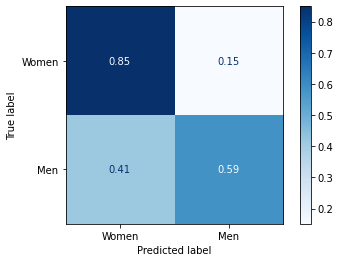

In [12]:
plot_confusion_matrix(naive_model, X_test, y_test, display_labels=['Women', 'Men'], cmap='Blues', normalize='true')
plt.show();

Evaluate the classifcation report.

In [13]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      8790
           1       0.58      0.59      0.58      3122

    accuracy                           0.78     11912
   macro avg       0.72      0.72      0.72     11912
weighted avg       0.78      0.78      0.78     11912



This model performs better classifying the female perfumes than the male perfumes.

For all further models we need to reduce the dimensionality.

### 4.7.2 Transform Data <a id='4.7.2_Transform_Data'></a>

In [14]:
# Select the columns
notes_columns = df.iloc[:,:-1]
notes_columns

,musk,sandalwood,jasmine,amber,patchouli,rose,vanilla,cedar,bergamot,vetiver,...,pink_peony,exotic_woods,fennel,white_lily,tomato_leaf,clover,sea_salt,rice,red_rose,other_notes
0,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47643,0,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47644,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47645,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47646,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
notes_pca = PCA().fit(notes_columns)
print(notes_pca)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)


In [16]:
print(notes_pca)
notes_pca.explained_variance_ratio_.cumsum()[0:100]

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)


array([0.0804832 , 0.1364319 , 0.1710333 , 0.20300796, 0.23074793,
       0.25771136, 0.28347223, 0.30750411, 0.32936958, 0.34844006,
       0.36475679, 0.37919775, 0.39308492, 0.40604428, 0.41817199,
       0.42986704, 0.44137458, 0.45241748, 0.46260852, 0.47275061,
       0.48259756, 0.49228096, 0.50131104, 0.50992998, 0.51848851,
       0.52665036, 0.5347182 , 0.54256253, 0.55024285, 0.55776002,
       0.56494405, 0.5719246 , 0.57875832, 0.58544397, 0.59207964,
       0.59851552, 0.60485107, 0.6111127 , 0.61720019, 0.62327688,
       0.62904388, 0.63473929, 0.64016574, 0.6455205 , 0.65079018,
       0.65600395, 0.66112767, 0.66597454, 0.67077224, 0.67547124,
       0.68006592, 0.68456433, 0.68902389, 0.69337596, 0.69763352,
       0.7017582 , 0.7058543 , 0.70990561, 0.7139007 , 0.71777448,
       0.72163771, 0.72540283, 0.72908402, 0.73274202, 0.73634912,
       0.7399242 , 0.74345142, 0.74692256, 0.75032054, 0.75365212,
       0.75695075, 0.76019087, 0.76339965, 0.76655392, 0.76967

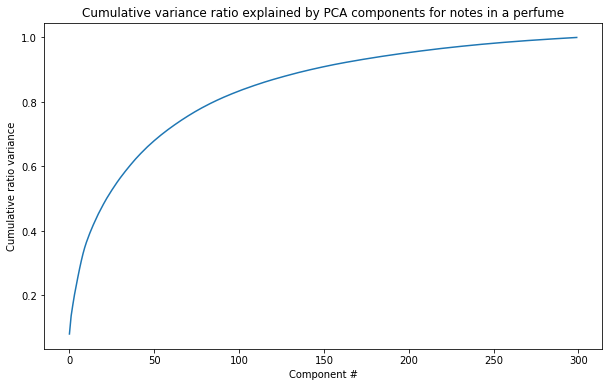

In [17]:
plt.subplots(figsize=(10, 6))
plt.plot(notes_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for notes in a perfume');

In [18]:
notes_pca_x = notes_pca.transform(notes_columns)

In [19]:
notes_pca_x.shape

(47648, 300)

In [20]:
notes_pca_selected_x = pd.DataFrame(notes_pca_x[:,:100])

In [21]:
notes_pca_selected_x.shape

(47648, 100)

In [22]:
notes_pca_selected_x.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.631846,0.230649,0.378716,0.183810,0.283986,-1.046740,0.015232,-0.239338,-0.124266,0.515686,...,0.295835,0.619911,0.384531,-0.340991,-0.143419,0.265725,-0.225142,-0.122967,0.056356,-0.056099
1,-0.448009,0.159253,-0.669996,0.441759,-0.621503,-0.333806,-0.005039,-0.430917,0.604678,0.058982,...,0.000512,0.016234,-0.020452,-0.025607,-0.011273,-0.008929,0.011199,-0.002673,0.028135,0.003187
2,-0.359715,-0.185678,-0.020530,-0.508041,0.531157,-0.367935,-0.197188,-0.737653,0.617330,-0.124639,...,0.006343,-0.008513,-0.006638,-0.012161,-0.011404,-0.002972,-0.014108,-0.025500,-0.012625,0.003053
3,-0.201730,-0.913128,-0.156368,-0.119412,-0.000304,-0.063671,-0.081120,-0.021250,-0.026750,-0.025915,...,0.014570,-0.080306,-0.041616,-0.059304,0.105484,-0.031203,-0.354262,0.465205,-0.202378,0.440226
4,-0.331265,-0.155809,0.360045,0.299362,0.321227,-1.032689,-0.020523,-0.257040,-0.108132,0.035656,...,-0.023979,-0.000439,-0.021622,0.014794,-0.002707,-0.009756,0.016130,-0.002822,0.000297,-0.008791


Let's pick up only the top 100 PCA columns.

Which features play the most important role?

In [23]:
loadings = pd.DataFrame(notes_pca.components_.T, index=df.columns[0:-1])
loadings

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
musk,-0.094052,0.443414,-0.593046,0.483178,0.055082,0.357836,0.148941,-0.080370,-0.085290,0.017582,...,-0.000782,0.000103,-0.000448,0.000700,0.000148,0.000164,-0.000373,0.000561,0.000318,-0.000965
sandalwood,-0.062925,0.378746,0.126419,-0.113320,0.736658,-0.365606,0.061511,-0.308910,-0.112953,-0.114556,...,-0.000557,0.000885,-0.000904,0.000417,-0.000228,0.000253,-0.000379,-0.001101,0.000021,0.000717
jasmine,-0.106330,0.430112,-0.050456,-0.421082,-0.198914,0.037416,-0.342868,0.369522,-0.431375,-0.210785,...,0.001233,-0.000303,0.000128,0.001150,0.000358,-0.000968,0.000305,-0.001368,0.000837,-0.000585
amber,-0.061760,0.298833,0.102919,0.374825,-0.482427,-0.701983,0.131926,0.015483,0.005760,-0.018822,...,-0.000296,0.000746,0.000482,-0.000128,-0.000699,0.001132,0.000075,-0.000046,0.000066,0.000083
patchouli,-0.033467,0.193300,0.553954,0.144054,-0.239173,0.417637,0.013443,-0.439422,-0.229666,-0.266696,...,-0.000627,0.001051,0.000830,-0.000206,-0.000406,-0.000795,0.000813,-0.000685,-0.000054,-0.000670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
clover,0.001410,-0.000215,-0.000162,0.000031,0.000073,-0.001103,-0.001031,0.000055,-0.000841,0.001870,...,-0.198423,-0.132273,0.277932,0.317191,0.687755,-0.268271,-0.225081,0.061089,0.209799,0.069522
sea_salt,0.001702,-0.000899,-0.001141,0.001202,0.000475,0.000409,-0.000659,0.000928,-0.000654,0.000832,...,-0.217718,-0.217026,0.298952,-0.210962,-0.151443,-0.060192,0.344979,-0.231764,0.424217,0.533000
rice,-0.000113,-0.000945,-0.001267,-0.001205,0.000421,-0.000517,-0.000434,-0.000947,0.000825,0.000517,...,-0.051172,0.193250,0.523393,0.434226,-0.010128,0.436170,0.359938,-0.199284,-0.181873,-0.230823
red_rose,0.001162,0.000547,-0.000033,-0.000601,0.000187,-0.000852,0.001648,-0.000740,-0.001874,-0.000561,...,0.436571,-0.238247,0.142004,0.142859,-0.110549,-0.054530,0.317609,0.555932,0.354945,-0.178062


We cannot find a specific field. All of them contribute one way or the other in this.

### 4.7.3 Split the newly transformed Data <a id='4.7.3_Split_PCA_Data'></a>

In [24]:
X_train, X_test, y_train, y_test = train_test_split(notes_pca_selected_x,
                                                    df.label, test_size=0.25, 
                                                    random_state=47)

In [25]:
X_train.shape, X_test.shape

((35736, 100), (11912, 100))

In [26]:
y_train.shape, y_test.shape

((35736,), (11912,))

In [27]:
#Code task 2#
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
       ...   
95    float64
96    float64
97    float64
98    float64
99    float64
Length: 100, dtype: object

In [28]:
#Code task 3#
#Repeat this check for the test split in `X_test`
X_test.dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
       ...   
95    float64
96    float64
97    float64
98    float64
99    float64
Length: 100, dtype: object

You have only numeric features in your X now!

### 4.7.4 Decision Tree Classifier <a id='4.7.4_Decision_Tree'></a>

Let's start our classification with the good old `DecisionTreeClassifier`.

In [29]:
# commenting this out as it takes too long to run. We have run this and got 6 as the best_param

# param_grid = {'max_depth': np.arange(1, 15)}

# dtree_model = DecisionTreeClassifier()
# dtree_cv = GridSearchCV(dtree_model, param_grid, cv=5)
# dtree_cv.fit(X_train, y_train)
# dtree_cv.best_params_

In [30]:
best_dtree_model = DecisionTreeClassifier(max_depth=6, random_state=0)
test_scores = cross_validate(best_dtree_model, X_train, y_train, cv=10)
test_scores

{'fit_time': array([4.6992197 , 4.63850212, 4.45558167, 4.5722487 , 4.55760121,
        4.40490389, 4.44587541, 4.50452495, 4.51471329, 4.47055721]),
 'score_time': array([0.04322767, 0.00099778, 0.01470995, 0.00623083, 0.01600003,
        0.00713778, 0.00804663, 0.01562953, 0.        , 0.        ]),
 'test_score': array([0.75433688, 0.75713486, 0.75153889, 0.74650252, 0.75993285,
        0.75769446, 0.7654632 , 0.75790652, 0.75034985, 0.76154492])}

In [31]:
best_dtree_model.fit(X_train, y_train)
dt_y_pred = best_dtree_model.predict(X_test)
best_dtree_model.score(X_test, y_test)

0.758226997985225

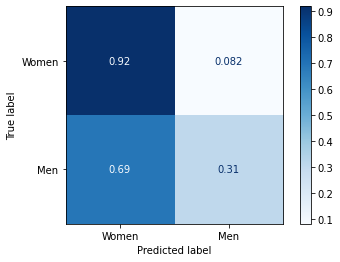

In [32]:
plot_confusion_matrix(best_dtree_model, X_test, y_test, display_labels=['Women', 'Men'], cmap='Blues', normalize='true')
plt.show();

Evaluate the classifcation report.

In [33]:
print(classification_report(y_test, dt_y_pred))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85      8790
           1       0.57      0.31      0.40      3122

    accuracy                           0.76     11912
   macro avg       0.68      0.61      0.62     11912
weighted avg       0.73      0.76      0.73     11912



This model has higher recall than the previous model in identifying the _female_ class. But the scores for the _male_ class has deteriorated.

In [34]:
test_scores = cross_validate(best_dtree_model, X_train, y_train, cv=10)
test_scores

{'fit_time': array([4.58860469, 4.48801708, 4.43671679, 4.39803004, 4.35372281,
        4.39228082, 4.40984392, 4.46021152, 4.4620111 , 4.4252696 ]),
 'score_time': array([0.01647663, 0.00814676, 0.00624156, 0.01574349, 0.00103307,
        0.00805378, 0.00599623, 0.        , 0.00919247, 0.        ]),
 'test_score': array([0.75433688, 0.75713486, 0.75153889, 0.74650252, 0.75993285,
        0.75769446, 0.7654632 , 0.75790652, 0.75034985, 0.76154492])}

On cross-validation that best possible score is 76%, less than the Naive Baye's classifer.

### 4.7.5 KNN Model<a id='4.7.5_KNN'></a>

In [35]:
# commenting this out as it takes too long to run. We have run this and got 5 as the best_param
# param_grid = {'n_neighbors': np.arange(1, 5)}

# knn_model = KNeighborsClassifier() 
# knn_cv = GridSearchCV(knn_model, param_grid, cv=5)
# knn_cv.fit(X_train, y_train)
# knn_cv.best_params_

In [36]:
best_knn_model = KNeighborsClassifier(n_neighbors=5)
test_scores = cross_validate(best_knn_model, X_train, y_train, cv=10)
test_scores

{'fit_time': array([2.52145267, 2.46606779, 2.47266674, 2.54535246, 2.63201547,
        2.40031362, 2.32227111, 2.36461353, 2.33576035, 2.52251863]),
 'score_time': array([46.42509913, 47.56363845, 47.85599232, 49.11627293, 46.27579999,
        47.41076326, 47.01583433, 47.86711979, 46.9147594 , 47.36323547]),
 'test_score': array([0.74790151, 0.75209849, 0.75181869, 0.75517627, 0.74594292,
        0.75657527, 0.7581864 , 0.76574307, 0.75202911, 0.75062972])}

In [37]:
best_knn_model.fit(X_train, y_train)
knn_y_pred = best_knn_model.predict(X_test)

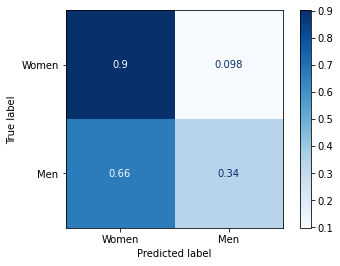

In [38]:
plot_confusion_matrix(best_knn_model, X_test, y_test, display_labels=['Women', 'Men'], cmap='Blues', normalize='true')
plt.show();

In [39]:
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      8790
           1       0.55      0.34      0.42      3122

    accuracy                           0.75     11912
   macro avg       0.67      0.62      0.63     11912
weighted avg       0.73      0.75      0.73     11912



### 4.7.6 Random Forest Model<a id='4.7.6_Random_Forest'></a>

In [41]:
# commenting this out as it takes too long to run. We have run this and got 100 as the best_param

# n_est = [int(n) for n in np.logspace(start=2, stop=3, num=10)]

# param_grid = {'n_estimators': n_est}

# rf_model = RandomForestClassifier()
# rf_cv = GridSearchCV(rf_model, param_grid, cv=5)
# rf_cv.fit(X_train, y_train)
# rf_cv.best_params_

In [42]:
best_rf_model = RandomForestClassifier(n_estimators=100)
test_scores = cross_validate(best_rf_model, X_train, y_train, cv=10)
test_scores

{'fit_time': array([83.14915323, 81.50836515, 82.32109189, 82.66121578, 78.70550656,
        80.06455779, 81.35136747, 80.6743679 , 81.51071715, 82.02045321]),
 'score_time': array([0.26660657, 0.24482179, 0.24902105, 0.23537278, 0.22879624,
        0.20220852, 0.24296379, 0.23870134, 0.23089242, 0.24299359]),
 'test_score': array([0.76301063, 0.77280358, 0.76580862, 0.77196419, 0.77504197,
        0.77560157, 0.77889729, 0.77861741, 0.76434369, 0.76434369])}

In [43]:
best_rf_model.fit(X_train, y_train)
rf_y_pred = best_rf_model.predict(X_test)

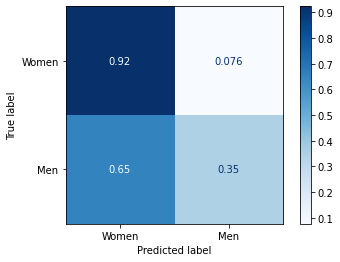

In [44]:
plot_confusion_matrix(best_rf_model, X_test, y_test, display_labels=['Women', 'Men'], cmap='Blues', normalize='true')
plt.show();

In [45]:
# 100 estimators
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.80      0.92      0.86      8790
           1       0.62      0.35      0.45      3122

    accuracy                           0.77     11912
   macro avg       0.71      0.64      0.65     11912
weighted avg       0.75      0.77      0.75     11912



### 4.7.7 AdaBoost Model<a id='4.7.7_Adaboost'></a>

In [46]:
# commenting this out as it takes too long to run. We have run this and got 100 as the best_param

# n_est = [int(n) for n in np.logspace(start=1, stop=2, num=10)]

# param_grid = {'n_estimators': n_est}

# ab_model = AdaBoostClassifier(n_estimators=100)
# ab_cv = GridSearchCV(rf_model, param_grid, cv=5)
# ab_cv.fit(X_train, y_train)
# ab_cv.best_params_

In [47]:
best_ab_model = AdaBoostClassifier(n_estimators=100)
test_scores = cross_validate(best_ab_model, X_train, y_train, cv=10)
test_scores

{'fit_time': array([91.06830645, 92.22489882, 91.01725125, 88.63262582, 90.53028297,
        91.6226058 , 96.51527214, 89.53341913, 89.65057874, 89.95858049]),
 'score_time': array([0.45488381, 0.35795975, 0.40177941, 0.37662601, 0.35381699,
        0.39767408, 0.44770718, 0.32953548, 0.33059955, 0.454561  ]),
 'test_score': array([0.77168439, 0.77196419, 0.77028539, 0.77588137, 0.78651371,
        0.77588137, 0.78449482, 0.7774979 , 0.77413938, 0.76322418])}

In [48]:
best_ab_model.fit(X_train, y_train)
rf_y_pred = best_ab_model.predict(X_test)

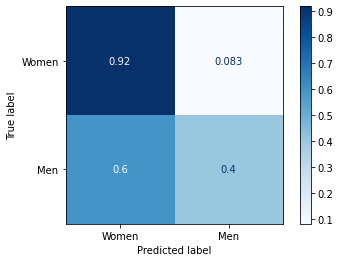

In [49]:
plot_confusion_matrix(best_ab_model, X_test, y_test, display_labels=['Women', 'Men'], cmap='Blues', normalize='true')
plt.show();

In [50]:
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      8790
           1       0.63      0.40      0.49      3122

    accuracy                           0.78     11912
   macro avg       0.72      0.66      0.68     11912
weighted avg       0.77      0.78      0.76     11912



### 4.7.8 Logisitic Regression Model<a id='4.7.8_Logistic_Regression'></a>

In [51]:
best_lr_model = LogisticRegression(random_state=0)
test_scores = cross_validate(best_lr_model, X_train, y_train, cv=10)
test_scores

{'fit_time': array([1.14843321, 0.62071347, 0.5169239 , 0.70791602, 0.52055573,
        0.53168344, 0.5072329 , 0.62589502, 0.51116681, 0.5311265 ]),
 'score_time': array([0.00369048, 0.00099468, 0.00414944, 0.00376058, 0.00682688,
        0.00299501, 0.00238061, 0.        , 0.00785208, 0.00099564]),
 'test_score': array([0.77951875, 0.78399552, 0.77728036, 0.78175713, 0.79266928,
        0.78343593, 0.78589421, 0.78281556, 0.78393507, 0.77301987])}

In [52]:
best_lr_model.fit(X_train, y_train)
lr_y_pred = best_lr_model.predict(X_test)

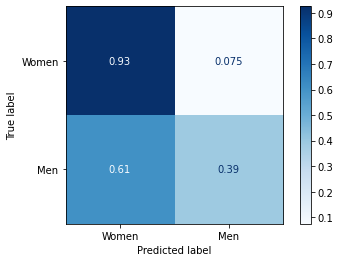

In [53]:
plot_confusion_matrix(best_lr_model, X_test, y_test, display_labels=['Women', 'Men'], cmap='Blues', normalize='true')
plt.show();

In [54]:
print(classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      8790
           1       0.65      0.39      0.49      3122

    accuracy                           0.79     11912
   macro avg       0.73      0.66      0.68     11912
weighted avg       0.77      0.79      0.77     11912



### 4.7.9 SVC Model<a id='4.7.9_SVM'></a>

In [55]:
best_sv_model = SVC()
test_scores = cross_validate(best_sv_model, X_train, y_train, cv=10)
test_scores

{'fit_time': array([ 411.28271532,  392.47533059, 1059.41308832,  401.85447264,
         402.03612828,  399.52203321,  408.2756443 ,  403.49373031,
         400.11470342,  401.31999373]),
 'score_time': array([17.32373142, 16.98905754, 16.36621094, 16.85726237, 16.40668559,
        17.54332399, 17.52417636, 16.50349474, 16.34176469, 16.91092396]),
 'test_score': array([0.78259653, 0.78707331, 0.77867935, 0.78371572, 0.7881925 ,
        0.78343593, 0.78813322, 0.7920515 , 0.78281556, 0.77665827])}

In [56]:
best_sv_model.fit(X_train, y_train)
sv_y_pred = best_sv_model.predict(X_test)

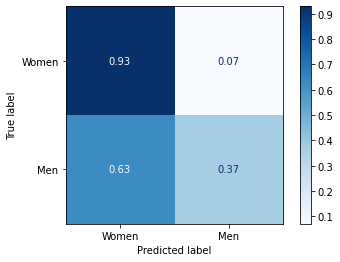

In [57]:
plot_confusion_matrix(best_sv_model, X_test, y_test, display_labels=['Women', 'Men'], cmap='Blues', normalize='true')
plt.show();

In [58]:
print(classification_report(y_test, sv_y_pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      8790
           1       0.65      0.37      0.48      3122

    accuracy                           0.78     11912
   macro avg       0.73      0.65      0.67     11912
weighted avg       0.77      0.78      0.76     11912



## 4.8 Summary<a id='4.8_Summary'></a>